In [1]:
import tensorflow as tf

physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    print('GPU device found:')
    for device in physical_devices:
        print(device)
else:
    print('No GPU devices found.')

GPU device found:
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [2]:
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)

In [3]:
SEED = 42
import os
os.environ['PYTHONHASHSEED'] = str(SEED)
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, applications, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def reset_seeds():
    np.random.seed(SEED)
    tf.random.set_seed(SEED)
    random.seed(SEED)

reset_seeds()

policy = tf.keras.mixed_precision.Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy(policy)

train_loc_vgg19 = './OfficialSpectrogramsMelAUG/train'
test_loc_vgg19 = './OfficialSpectrogramsMelAUG/test'

train_loc_vgg16 = './OfficialSpectrogramsMelAUG/train'
test_loc_vgg16 = './OfficialSpectrogramsMelAUG/test'

# Definir la normalización
train_datagen = ImageDataGenerator(
    rescale=1./255,
)

test_datagen = ImageDataGenerator(
    rescale=1./255,
)

batch_size = 32

# Crear los generadores de datos para VGG19
train_generator_vgg19 = train_datagen.flow_from_directory(
    directory=train_loc_vgg19,
    target_size=(224, 224),
    batch_size=batch_size,
    shuffle=True,
    seed=SEED
)

test_generator_vgg19 = test_datagen.flow_from_directory(
    directory=test_loc_vgg19,
    target_size=(224, 224),
    batch_size=batch_size,
    shuffle=False,
    seed=SEED
)

# Crear los generadores de datos para VGG16
train_generator_vgg16 = train_datagen.flow_from_directory(
    directory=train_loc_vgg16,
    target_size=(224, 224),
    batch_size=batch_size,
    shuffle=True,
    seed=SEED
)

test_generator_vgg16 = test_datagen.flow_from_directory(
    directory=test_loc_vgg16,
    target_size=(224, 224),
    batch_size=batch_size,
    shuffle=False,
    seed=SEED
)

# Obtener los nombres de las clases
class_names = list(train_generator_vgg19.class_indices.keys())
print("Class names:", class_names)

# Verificar que las clases sean iguales
assert list(train_generator_vgg19.class_indices.keys()) == list(train_generator_vgg16.class_indices.keys()), "Las clases de los datasets no coinciden"

# VGG19 branch
vgg19_base = applications.VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in vgg19_base.layers:
    layer._name = "vgg19_" + layer.name

vgg19_x = layers.Flatten(name='vgg19_flatten')(vgg19_base.output)
vgg19_x = layers.Dense(256, activation='relu', name='vgg19_dense')(vgg19_x)

# VGG16 branch
vgg16_base = applications.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in vgg16_base.layers:
    layer._name = "vgg16_" + layer.name

vgg16_x = layers.Flatten(name='vgg16_flatten')(vgg16_base.output)
vgg16_x = layers.Dense(256, activation='relu', name='vgg16_dense')(vgg16_x)

# Concatenate
combined = layers.Concatenate(name='concatenate')([vgg19_x, vgg16_x])

# Output layer
z = layers.Dense(128, activation='relu', name='combined_dense')(combined)
z = layers.Dense(len(class_names), activation='softmax', name='output')(z)

# Define the model
model = models.Model(inputs=[vgg19_base.input, vgg16_base.input], outputs=z)

# Freeze layers
for layer in vgg19_base.layers:
    layer.trainable = False

for layer in vgg19_base.layers[-23:]:
    layer.trainable = True
    print(f"Layer '{layer.name}' is trainable")

for layer in vgg16_base.layers:
    layer.trainable = False

for layer in vgg16_base.layers[-20:]:
    layer.trainable = True
    print(f"Layer '{layer.name}' is trainable")

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001),
    loss=tf.keras.losses.categorical_crossentropy,
    metrics=['accuracy']
)

# Print the model summary
model.summary()

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 4090, compute capability 8.9
Found 8544 images belonging to 4 classes.
Found 2756 images belonging to 4 classes.
Found 8544 images belonging to 4 classes.
Found 2756 images belonging to 4 classes.
Class names: ['crackle', 'crackle_wheeze', 'normal', 'wheeze']
Layer 'vgg19_input_1' is trainable
Layer 'vgg19_block1_conv1' is trainable
Layer 'vgg19_block1_conv2' is trainable
Layer 'vgg19_block1_pool' is trainable
Layer 'vgg19_block2_conv1' is trainable
Layer 'vgg19_block2_conv2' is trainable
Layer 'vgg19_block2_pool' is trainable
Layer 'vgg19_block3_conv1' is trainable
Layer 'vgg19_block3_conv2' is trainable
Layer 'vgg19_block3_conv3' is trainable
Layer 'vgg19_block3_conv4' is trainable
Layer 'vgg19_block3_pool' is trainable
Layer 'vgg19_block4_conv1' is trainable
Layer 'vgg19_blo

In [4]:
import os

class CustomModelCheckpoint(callbacks.Callback):
    def __init__(self, filepath, monitor1='val_accuracy', monitor2='val_loss', mode1='max', mode2='min', save_best_only=True, ignore_initial_epochs=15, verbose=0, loss_threshold=2.5):
        super().__init__()
        self.filepath = filepath
        self.monitor1 = monitor1
        self.monitor2 = monitor2
        self.mode1 = mode1
        self.mode2 = mode2
        self.save_best_only = save_best_only
        self.ignore_initial_epochs = ignore_initial_epochs
        self.verbose = verbose
        self.loss_threshold = loss_threshold
        self.best = None
        self.best_epoch = -1

    def on_epoch_end(self, epoch, logs=None):
        if epoch < self.ignore_initial_epochs:
            return

        current1 = logs.get(self.monitor1)
        current2 = logs.get(self.monitor2)

        if current2 < self.loss_threshold and (self.best is None or self._compare(current1, self.best, self.mode1)):
            self.best = current1
            self.best_epoch = epoch
            if self.verbose > 0:
                print(f"\nEpoch {epoch + 1}: {self.monitor1} improved to {current1}, {self.monitor2} is {current2}, saving model to {self.filepath}")
            if self.save_best_only:
                self.model.save(self.filepath, save_format='tf', overwrite=True)
            else:
                self.model.save(self.filepath.format(epoch=epoch, **logs), save_format='tf')          
        else:
            if self.verbose > 0:
                print(f"\nEpoch {epoch + 1}: {self.monitor1} did not improve from {self.best}, {self.monitor2} is {current2}")

    def _compare(self, current, best, mode):
        if best is None:
            return True
        if mode == 'max':
            return current > best
        else:  # mode == 'min'
            return current < best

# Callback para early stopping
class CustomEarlyStopping(callbacks.EarlyStopping):
    def __init__(self, monitor='val_accuracy', min_delta=0, patience=60, verbose=1, mode='max', ignore_initial_epochs=1):
        super().__init__(monitor=monitor, min_delta=min_delta, patience=patience, verbose=verbose, mode=mode)
        self.ignore_initial_epochs = ignore_initial_epochs

    def on_epoch_end(self, epoch, logs=None):
        if epoch < self.ignore_initial_epochs:
            return
        super().on_epoch_end(epoch, logs)

# Path para guardar el modelo
checkpoint_path = './Best_Models/Tests/RMSprop/Custom_RMSprop_0001'

# Crear los callbacks
checkpoint_callback = CustomModelCheckpoint(
    filepath=checkpoint_path,
    monitor1='val_accuracy',
    monitor2='val_loss',
    mode1='max',
    mode2='min',
    save_best_only=True,
    ignore_initial_epochs=1,
    verbose=1,
    loss_threshold=2.5
)

early_stopping_callback = CustomEarlyStopping(
    monitor='val_loss',
    patience=40,
    verbose=1,
    mode='min',
    ignore_initial_epochs=1
)

In [5]:
from collections import Counter

counter_vgg19 = Counter(train_generator_vgg19.classes)
max_val_vgg19 = float(max(counter_vgg19.values()))
class_weights_vgg19 = {class_id : max_val_vgg19 / num_images for class_id, num_images in counter_vgg19.items()}
print("Class weights for VGG19:", class_weights_vgg19)

counter_vgg16 = Counter(train_generator_vgg16.classes)
max_val_vgg16 = float(max(counter_vgg16.values()))
class_weights_vgg16 = {class_id : max_val_vgg16 / num_images for class_id, num_images in counter_vgg16.items()}
print("Class weights for VGG16:", class_weights_vgg16)

# Verificar que ambos diccionarios sean iguales
assert class_weights_vgg19 == class_weights_vgg16, "Los class_weights de los datasets no coinciden"
class_weights = class_weights_vgg19  # Ambos son iguales, puedes usar cualquiera de los dos

Class weights for VGG19: {0: 1.0, 1: 1.564657393096342, 2: 1.4721279689772175, 3: 2.0206254158349966}
Class weights for VGG16: {0: 1.0, 1: 1.564657393096342, 2: 1.4721279689772175, 3: 2.0206254158349966}


In [6]:
def combined_generator(generator1, generator2):
    while True:
        batch1 = next(generator1)
        batch2 = next(generator2)
        yield [batch1[0], batch2[0]], batch1[1]

train_combined_generator = combined_generator(train_generator_vgg19, train_generator_vgg16)
validation_combined_generator = combined_generator(test_generator_vgg19, test_generator_vgg16)

steps_per_epoch = train_generator_vgg19.samples // train_generator_vgg19.batch_size
validation_steps = test_generator_vgg19.samples // test_generator_vgg19.batch_size

# Ajuste final con callbacks
history = model.fit(
    train_combined_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_combined_generator,
    validation_steps=validation_steps,
    epochs=250,
    callbacks=[checkpoint_callback, early_stopping_callback],
    verbose=2,
    class_weight=class_weights
)

# Evaluar el modelo
loss, accuracy = model.evaluate(validation_combined_generator, steps=validation_steps)
print("Validation loss:", loss)
print("Validation accuracy:", accuracy)

Epoch 1/250
267/267 - 42s - loss: 1.9374 - accuracy: 0.3421 - val_loss: 1.3021 - val_accuracy: 0.4749 - 42s/epoch - 159ms/step
Epoch 2/250

Epoch 2: val_accuracy improved to 0.4593023359775543, val_loss is 1.5276503562927246, saving model to ./Best_Models/Tests/RMSprop/Custom_RMSprop_0001


INFO:tensorflow:Assets written to: ./Best_Models/Tests/RMSprop/Custom_RMSprop_0001\assets


INFO:tensorflow:Assets written to: ./Best_Models/Tests/RMSprop/Custom_RMSprop_0001\assets


267/267 - 38s - loss: 1.5620 - accuracy: 0.5166 - val_loss: 1.5277 - val_accuracy: 0.4593 - 38s/epoch - 143ms/step
Epoch 3/250

Epoch 3: val_accuracy did not improve from 0.4593023359775543, val_loss is 1.6703647375106812
267/267 - 36s - loss: 1.4108 - accuracy: 0.5755 - val_loss: 1.6704 - val_accuracy: 0.4564 - 36s/epoch - 136ms/step
Epoch 4/250

Epoch 4: val_accuracy did not improve from 0.4593023359775543, val_loss is 1.7827205657958984
267/267 - 36s - loss: 1.2907 - accuracy: 0.6163 - val_loss: 1.7827 - val_accuracy: 0.4259 - 36s/epoch - 136ms/step
Epoch 5/250

Epoch 5: val_accuracy improved to 0.5007267594337463, val_loss is 1.5967847108840942, saving model to ./Best_Models/Tests/RMSprop/Custom_RMSprop_0001


INFO:tensorflow:Assets written to: ./Best_Models/Tests/RMSprop/Custom_RMSprop_0001\assets


INFO:tensorflow:Assets written to: ./Best_Models/Tests/RMSprop/Custom_RMSprop_0001\assets


267/267 - 38s - loss: 1.1830 - accuracy: 0.6537 - val_loss: 1.5968 - val_accuracy: 0.5007 - 38s/epoch - 143ms/step
Epoch 6/250

Epoch 6: val_accuracy did not improve from 0.5007267594337463, val_loss is 1.5669825077056885
267/267 - 36s - loss: 1.1058 - accuracy: 0.6709 - val_loss: 1.5670 - val_accuracy: 0.4982 - 36s/epoch - 136ms/step
Epoch 7/250

Epoch 7: val_accuracy did not improve from 0.5007267594337463, val_loss is 2.019383668899536
267/267 - 36s - loss: 1.0293 - accuracy: 0.7005 - val_loss: 2.0194 - val_accuracy: 0.4637 - 36s/epoch - 136ms/step
Epoch 8/250

Epoch 8: val_accuracy did not improve from 0.5007267594337463, val_loss is 2.2769293785095215
267/267 - 36s - loss: 0.9339 - accuracy: 0.7289 - val_loss: 2.2769 - val_accuracy: 0.4019 - 36s/epoch - 135ms/step
Epoch 9/250

Epoch 9: val_accuracy did not improve from 0.5007267594337463, val_loss is 1.9471805095672607
267/267 - 36s - loss: 0.8739 - accuracy: 0.7534 - val_loss: 1.9472 - val_accuracy: 0.4157 - 36s/epoch - 135ms/ste

INFO:tensorflow:Assets written to: ./Best_Models/Tests/RMSprop/Custom_RMSprop_0001\assets


INFO:tensorflow:Assets written to: ./Best_Models/Tests/RMSprop/Custom_RMSprop_0001\assets


267/267 - 38s - loss: 0.8141 - accuracy: 0.7667 - val_loss: 1.6285 - val_accuracy: 0.5084 - 38s/epoch - 143ms/step
Epoch 11/250

Epoch 11: val_accuracy did not improve from 0.508357584476471, val_loss is 1.9812607765197754
267/267 - 37s - loss: 0.7620 - accuracy: 0.7901 - val_loss: 1.9813 - val_accuracy: 0.4818 - 37s/epoch - 137ms/step
Epoch 12/250

Epoch 12: val_accuracy did not improve from 0.508357584476471, val_loss is 2.5579352378845215
267/267 - 36s - loss: 0.6975 - accuracy: 0.8037 - val_loss: 2.5579 - val_accuracy: 0.4633 - 36s/epoch - 136ms/step
Epoch 13/250

Epoch 13: val_accuracy did not improve from 0.508357584476471, val_loss is 1.7114654779434204
267/267 - 36s - loss: 0.6518 - accuracy: 0.8144 - val_loss: 1.7115 - val_accuracy: 0.4964 - 36s/epoch - 136ms/step
Epoch 14/250

Epoch 14: val_accuracy did not improve from 0.508357584476471, val_loss is 1.8154467344284058
267/267 - 36s - loss: 0.6201 - accuracy: 0.8311 - val_loss: 1.8154 - val_accuracy: 0.4695 - 36s/epoch - 136m

INFO:tensorflow:Assets written to: ./Best_Models/Tests/RMSprop/Custom_RMSprop_0001\assets


INFO:tensorflow:Assets written to: ./Best_Models/Tests/RMSprop/Custom_RMSprop_0001\assets


267/267 - 39s - loss: 0.5409 - accuracy: 0.8615 - val_loss: 2.2097 - val_accuracy: 0.5214 - 39s/epoch - 144ms/step
Epoch 18/250

Epoch 18: val_accuracy did not improve from 0.5214389562606812, val_loss is 3.570125102996826
267/267 - 37s - loss: 0.5073 - accuracy: 0.8670 - val_loss: 3.5701 - val_accuracy: 0.4873 - 37s/epoch - 138ms/step
Epoch 19/250

Epoch 19: val_accuracy did not improve from 0.5214389562606812, val_loss is 1.9952647686004639
267/267 - 36s - loss: 0.4699 - accuracy: 0.8716 - val_loss: 1.9953 - val_accuracy: 0.5153 - 36s/epoch - 137ms/step
Epoch 20/250

Epoch 20: val_accuracy did not improve from 0.5214389562606812, val_loss is 2.7320172786712646
267/267 - 37s - loss: 0.4561 - accuracy: 0.8783 - val_loss: 2.7320 - val_accuracy: 0.4775 - 37s/epoch - 137ms/step
Epoch 21/250

Epoch 21: val_accuracy did not improve from 0.5214389562606812, val_loss is 2.738712787628174
267/267 - 37s - loss: 0.4405 - accuracy: 0.8820 - val_loss: 2.7387 - val_accuracy: 0.4742 - 37s/epoch - 13

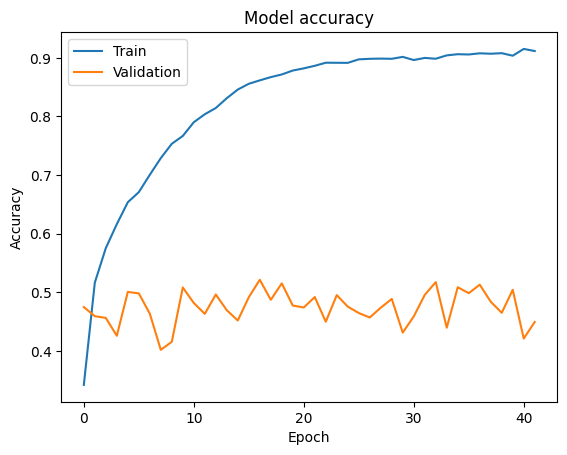

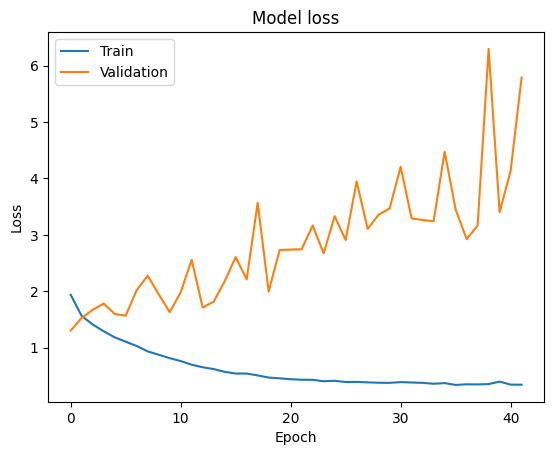

In [7]:
import matplotlib.pyplot as plt

# Plotear el accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plotear el loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [8]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

# Predicciones en el conjunto de prueba
predictions = model.predict(validation_combined_generator, steps=validation_steps)

# Obtener las etiquetas verdaderas del conjunto de prueba
y_true = test_generator_vgg19.classes[:len(predictions)]  # Asegúrate de que la longitud coincida

# Convertir las predicciones en etiquetas de clase
y_pred_classes = np.argmax(predictions, axis=1)

# Calcular métricas
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')

# Mostrar las métricas
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Obtener el número total de predicciones correctas para cada clase
Pc = sum((y_true == 0) & (y_pred_classes == 0))  # Crackle
Pb = sum((y_true == 1) & (y_pred_classes == 1))  # Both
Pn = sum((y_true == 2) & (y_pred_classes == 2))  # Normal
Pw = sum((y_true == 3) & (y_pred_classes == 3))  # Wheeze

# Obtener el total de muestras para cada clase
Crackle_total = sum(y_true == 0)  # Total de muestras de la clase Crackle
Both_total = sum(y_true == 1)     # Total de muestras de la clase Both
Normal_total = sum(y_true == 2)   # Total de muestras de la clase Normal
Wheeze_total = sum(y_true == 3)   # Total de muestras de la clase Wheeze

# Calcular el puntaje Se (Sensibilidad)
Se = (Pc + Pw + Pb) / (Crackle_total + Wheeze_total + Both_total)

# Calcular el puntaje Sp (Especificidad)
Sp = Pn / Normal_total

# Calcular el puntaje promedio
score = (Se + Sp) / 2

# Mostrar los resultados
print("Puntaje de Sensibilidad (Se):", Se)
print("Puntaje de Especificidad (Sp):", Sp)
print("Puntaje promedio:", score)

86/86 [==============================] - 10s 111ms/step
Accuracy: 0.44949127906976744
Precision: 0.4926777796978111
Recall: 0.44949127906976744
F1 Score: 0.4664538116564878
Puntaje de Sensibilidad (Se): 0.34612105711849955
Puntaje de Especificidad (Sp): 0.526282457251425
Puntaje promedio: 0.43620175718496224


In [9]:
# Mostrar el informe de clasificación
class_report = classification_report(y_true, y_pred_classes, target_names=class_names)
print("Classification Report:")
print(class_report)

Classification Report:
                precision    recall  f1-score   support

       crackle       0.35      0.38      0.37       649
crackle_wheeze       0.10      0.19      0.13       143
        normal       0.64      0.53      0.58      1579
        wheeze       0.26      0.34      0.30       381

      accuracy                           0.45      2752
     macro avg       0.34      0.36      0.34      2752
  weighted avg       0.49      0.45      0.47      2752



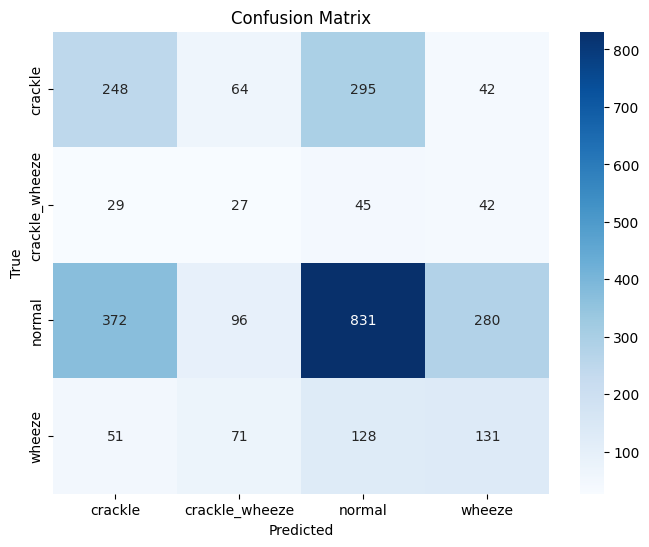

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# Función para mostrar la matriz de confusión
def plot_confusion_matrix(y_true, y_pred, class_names):
    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Calcular y mostrar la matriz de confusión
plot_confusion_matrix(y_true, y_pred_classes, class_names)

In [11]:
# Save the trained model
#model.save('./Best_Models/Tests/RMSprop/Custom_RMSprop_0001')